In [1]:
refit_swing_models=False
pitch_type_column="pitch_cluster"

rerun_optuna=False
load_string_init="2025_08_07"

In [2]:
%run saber_sem_init.py
from saber_sem_utils import *
from saber_sem_plotting import *

today_string = datetime.today().strftime("%Y_%m_%d")

In [3]:
load_string,swing_df,df = read_data_and_initialize(
    refit_swing_models,
    rerun_optuna,
    load_string_init,
)

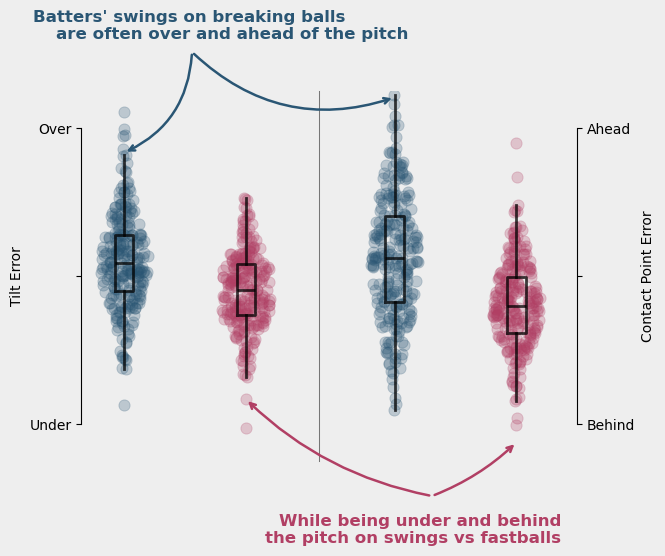

In [4]:
fastball_vs_breaking_ball_plot(swing_df)

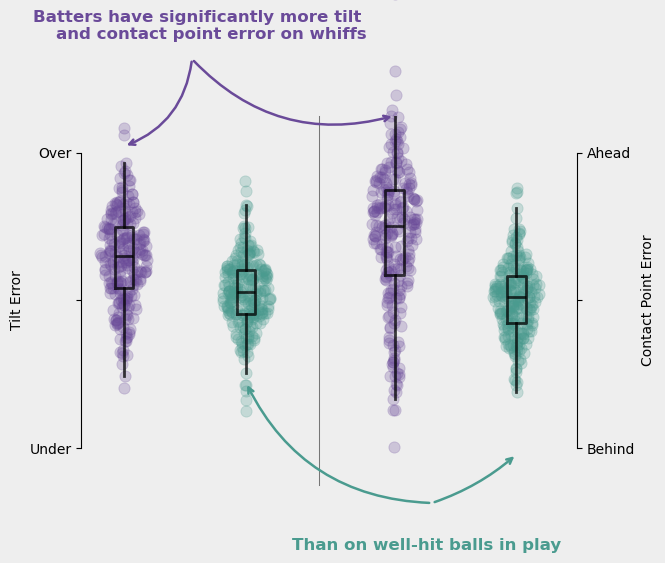

In [5]:
whiff_well_hit_validation_plot(swing_df)

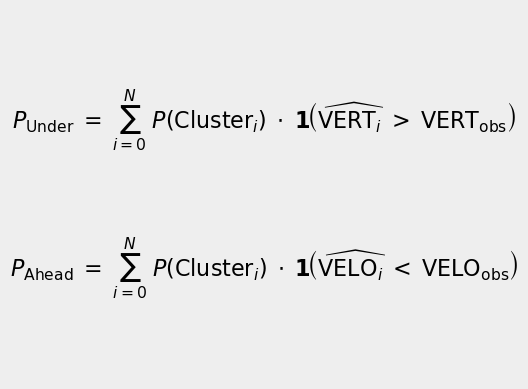

In [6]:
equation_plots()

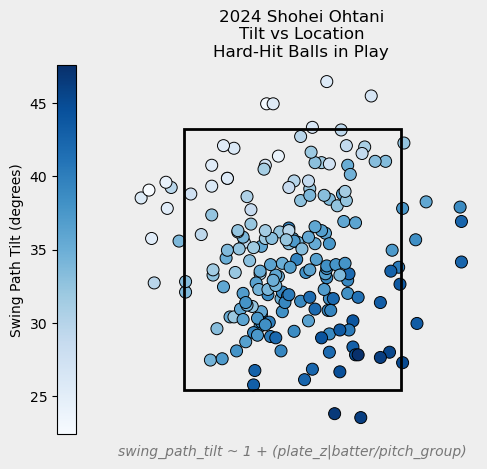

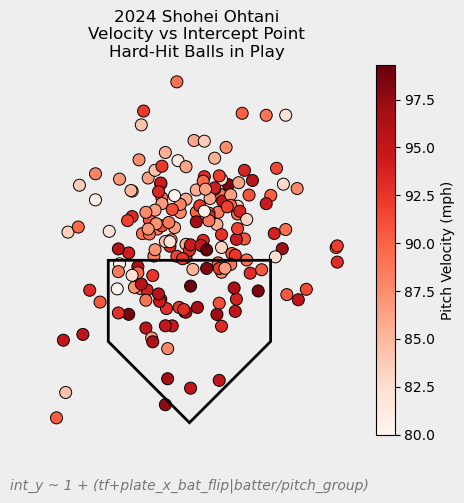

In [7]:
shohei_plots(swing_df)

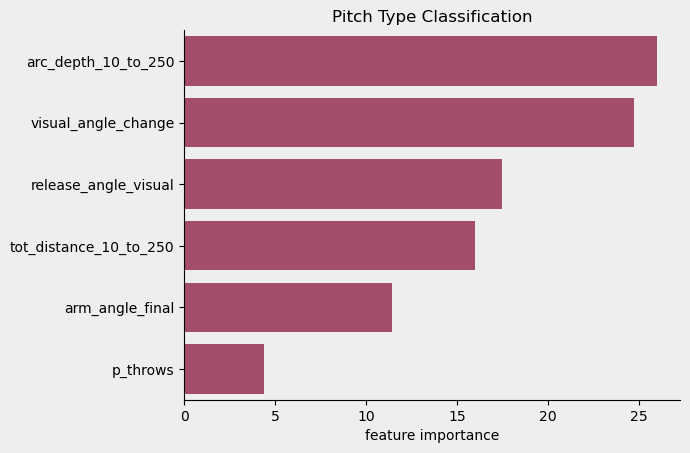

In [8]:
swing_df, under_auc, ahead_auc, total_auc, under_brier, ahead_brier, total_brier = update_predicted_pitch_types(
    swing_df,
    pred_pitch_type_x_vars=[
        "arm_angle_final",
        "tot_distance_10_to_250",
        "arc_depth_10_to_250",
        "visual_angle_change",        
        "release_angle_visual",
        "p_throws",
    ],
    refit=False,
    catboost_verbose=False,
    pitch_type_column=pitch_type_column,
    predicted_pitch_types_model_name="initial_pitch_cluster_catboost",
)

plot_feature_importances(
    predicted_pitch_types_model_name="initial_pitch_cluster_catboost",
    title="Pitch Type Classification",
)

In [9]:
if rerun_optuna:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    
    def print_callback(study_three, trial):
        print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")
        
        if trial.number % 5 == 0:
            print(f"Current best value: {study_three.best_value} with params: {study_three.best_params}")
            print("-" * 50)
    
    trial_log = []
    
    def objective(trial):
    
        global swing_df
        global pitch_type_column
        
        arm_angle_cuts=trial.suggest_int("arm_angle_cuts",1,10)*2
        tot_distance_cuts=trial.suggest_int("tot_distance_cuts",10,50)*2
        arc_depth_cuts=trial.suggest_int("arc_depth_cuts",10,50)*2
        visual_angle_change_cuts=trial.suggest_int("visual_angle_change_cuts",1,20)*2
        decision_point_location=trial.suggest_int("decision_point_location",5,25)
        release_angle_visual_cuts=trial.suggest_int("release_angle_visual_cuts",1,50)*2
        dec_pt_loc=10*decision_point_location
    
        swing_df = pl.from_pandas(add_arc_meas(swing_df.to_pandas(),dec_pt_loc))
    
        swing_df = swing_df.with_columns(
            pl.col("arm_angle_final")
            .qcut(arm_angle_cuts, labels=[str(_) for _ in np.arange(arm_angle_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias("arm_angle_final_cut"),
            pl.col("release_angle_visual")
            .qcut(release_angle_visual_cuts, labels=[str(_) for _ in np.arange(release_angle_visual_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias("release_angle_visual_cut"),
            pl.col(f"tot_distance_10_to_{dec_pt_loc}")
            .qcut(tot_distance_cuts, labels=[str(_) for _ in np.arange(tot_distance_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"tot_distance_10_to_{dec_pt_loc}_cut"),
            pl.col(f"arc_depth_10_to_{dec_pt_loc}")
            .qcut(arc_depth_cuts, labels=[str(_) for _ in np.arange(arc_depth_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"arc_depth_10_to_{dec_pt_loc}_cut"),
            pl.col(f"visual_angle_change_10_to_{dec_pt_loc}")
            .qcut(visual_angle_change_cuts, labels=[str(_) for _ in np.arange(visual_angle_change_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"visual_angle_change_10_to_{dec_pt_loc}_cut"),
        )
        
        swing_df, under_auc, ahead_auc, total_auc, under_brier, ahead_brier, total_brier = update_predicted_pitch_types(
            swing_df,
            pred_pitch_type_x_vars=[
                "arm_angle_final_cut",
                f"tot_distance_10_to_{dec_pt_loc}_cut",
                f"arc_depth_10_to_{dec_pt_loc}_cut",
                f"visual_angle_change_10_to_{dec_pt_loc}_cut",    
                "release_angle_visual_cut",
                "p_throws",
            ],
            catboost_verbose=False,
            pitch_type_column=pitch_type_column,
            predicted_pitch_types_model_name="optimized_pitch_cluster_catboost",
        )
        
        cluster_auc = pd.DataFrame(index=swing_df[pitch_type_column].unique(),columns=["AUC"])
        
        for i, pitch_cluster in enumerate(swing_df[pitch_type_column].unique()):
            if f"is_cluster_{pitch_cluster}" not in swing_df.columns:
                swing_df = swing_df.with_columns((pl.col(pitch_type_column)==pitch_cluster).cast(pl.Int32).alias(f"is_cluster_{pitch_cluster}"))
            _auc = roc_auc_score(
                swing_df[f"is_cluster_{pitch_cluster}"].to_numpy(),
                swing_df[f"cluster_{pitch_cluster}_pred_cb"].to_numpy()
            )
            cluster_auc.loc[pitch_cluster,"AUC"]=_auc
        
        cluster_auc.loc["mean","AUC"] = cluster_auc.loc[swing_df[pitch_type_column].unique(),"AUC"].mean()
        
        mean_cluster_auc = cluster_auc.loc[swing_df[pitch_type_column].unique(), "AUC"].mean()
    
        # Log trial info
        trial_log.append({
            "trial_number": trial.number,
            "params": trial.params,
            "under_auc": under_auc,
            "ahead_auc": ahead_auc,
            "total_auc": total_auc,
            "mean_cluster_auc": mean_cluster_auc,
            "under_brier": under_brier,
            "ahead_brier": ahead_brier,
            "total_brier": total_brier,
        })
    
        return total_brier
    
    
    sampler = TPESampler(seed=3024)
    
    swing_miss_model_opt = optuna.create_study(
        study_name="swing_miss_model_opt", 
        direction="minimize", 
        sampler=sampler,
    )
    
    swing_miss_model_opt.optimize(
        objective, 
        n_trials=500, 
        callbacks=[print_callback],
    )
    
    best_trial = swing_miss_model_opt.best_trial

    swing_miss_model_opt.trials_dataframe().copy().to_csv(f"swing_miss_model_opt_results_{today_string}_{pitch_type_column}.csv")
    
    trial_df = pd.DataFrame(trial_log)
    trial_df.to_csv(f"swing_miss_model_opt_results_{today_string}_{pitch_type_column}_additional_log.csv")
    
    provide_optuna_results(swing_miss_model_opt)
    plot_study_results_gam(swing_miss_model_opt.trials_dataframe().copy())

In [10]:
results_df=pd.read_csv(f"swing_miss_model_opt_results_{load_string}_{pitch_type_column}.csv").dropna(subset=["value"])
trial_df=pd.read_csv(f"swing_miss_model_opt_results_{load_string}_{pitch_type_column}_additional_log.csv")

for col in trial_df.columns:
    if "auc" in col or "brier" in col:
        results_df[col]=trial_df[col].values

for cut_col in [col for col in results_df.columns if "cut" in col]:
    results_df[cut_col] = pd.read_csv(f"swing_miss_model_opt_results_{load_string}_{pitch_type_column}.csv").dropna(subset=["value"])[cut_col].mul(2).values

results_df = results_df.assign(params_decision_point_location=lambda df:df["params_decision_point_location"].mul(10))

results_df[[col for col in results_df.columns if "auc" in col or "brier" in col]].corr()

,under_auc,ahead_auc,total_auc,mean_cluster_auc,under_brier,ahead_brier,total_brier
under_auc,1.000000,0.595929,0.742569,-0.743295,-0.918659,-0.718362,-0.817529
ahead_auc,0.595929,1.000000,0.980368,-0.682952,-0.581772,-0.921677,-0.849888
total_auc,0.742569,0.980368,1.000000,-0.752120,-0.710789,-0.945105,-0.909578
mean_cluster_auc,-0.743295,-0.682952,-0.752120,1.000000,0.920214,0.904113,0.950236
under_brier,-0.918659,-0.581772,-0.710789,0.920214,1.000000,0.805750,0.906840
ahead_brier,-0.718362,-0.921677,-0.945105,0.904113,0.805750,1.000000,0.980307
total_brier,-0.817529,-0.849888,-0.909578,0.950236,0.906840,0.980307,1.000000


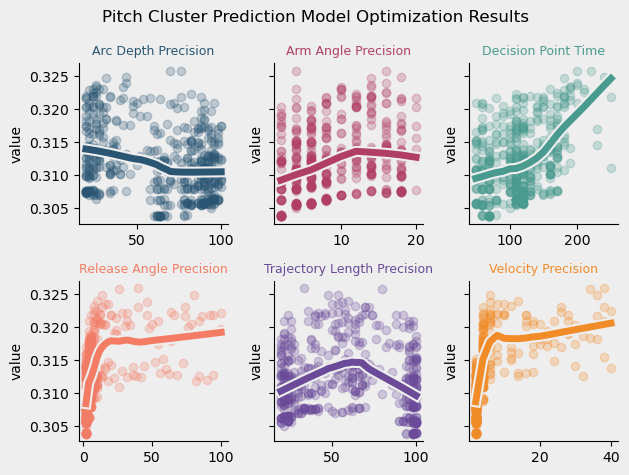

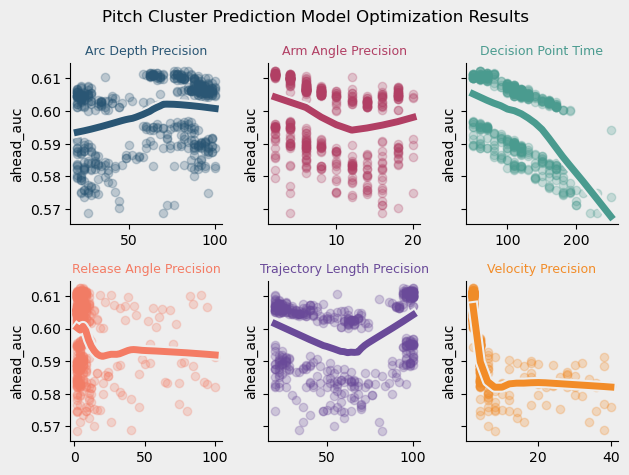

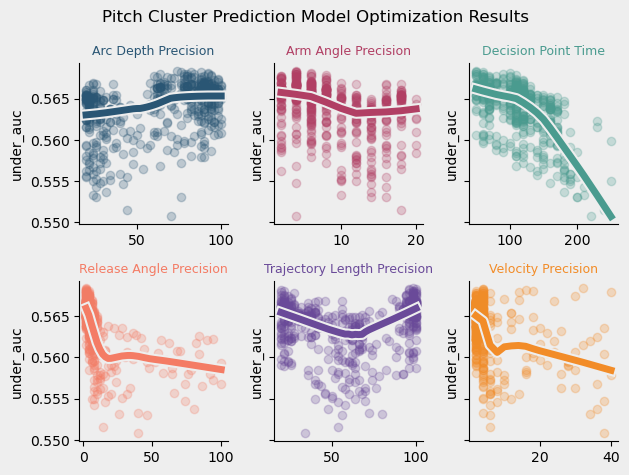

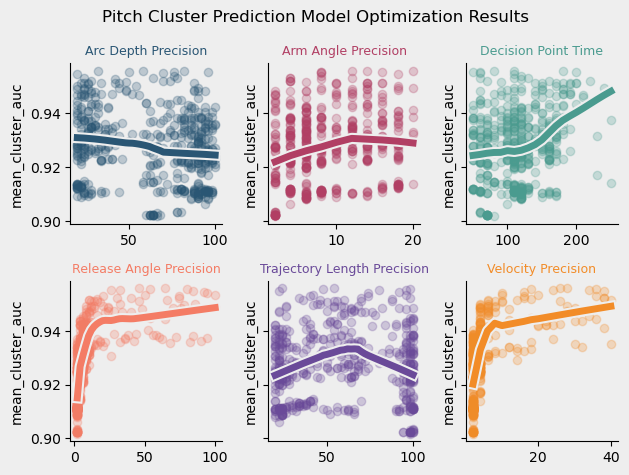

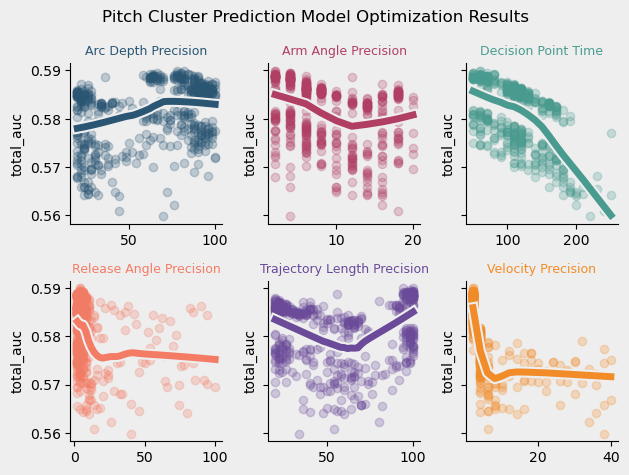

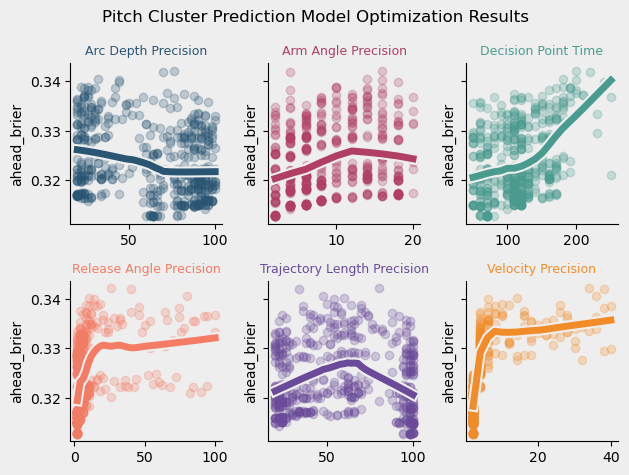

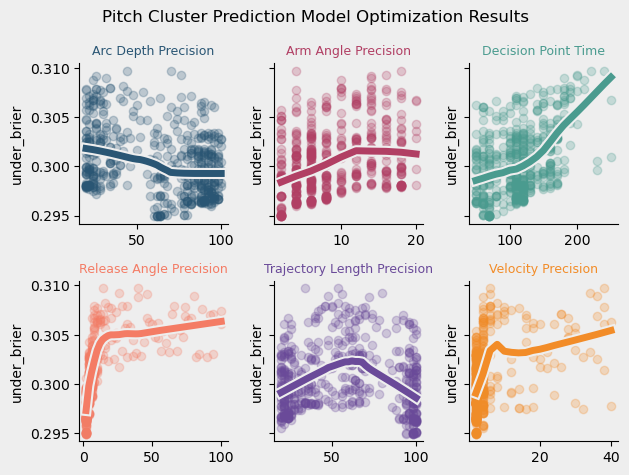

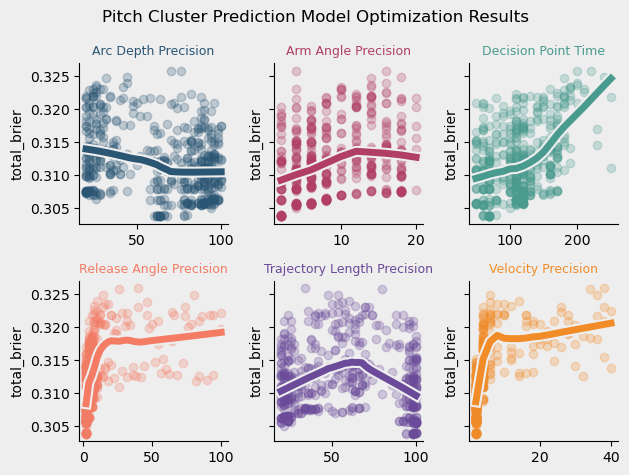

In [11]:
generic_results_plots(
    results_df,
    param_cols=3,
    y_cols=["value","ahead_auc","under_auc","mean_cluster_auc","total_auc","ahead_brier","under_brier","total_brier"],
    title_string="Pitch Cluster Prediction Model Optimization Results",    
)

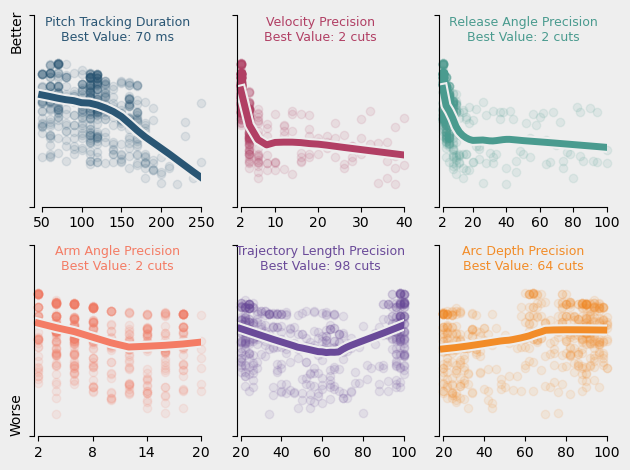

In [12]:
param_cols = 3
y_column="total_brier"

params_dict = {
    "decision_point_location":{
        "title":"Pitch Tracking Duration",
        "xlimits":[40,250],
        "xbounds":[50,250],
        "xticks":np.arange(50,300,50),
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "visual_angle_change_cuts":{
        "title":"Velocity Precision",
        "xlimits":[1,40],
        "xbounds":[2,40],
        # "xticks":np.arange(2,26,6),
        "xticks":[2,10,20,30,40],
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "release_angle_visual_cuts":{
        "title":"Release Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.22,
        "rank":3,
    },
    "arm_angle_cuts":{
        "title":"Arm Angle Precision",
        "xlimits":[1.5,20],
        "xbounds":[2,20],
        "xticks":np.arange(2,26,6),
        "importance":0.06,
        "rank":4,
    },
    "tot_distance_cuts":{
        "title":"Trajectory Length Precision",
        "xlimits":[18,100],
        "xbounds":[20,100],
        "xticks":np.arange(20,120,20),
        "importance":0.02,
        "rank":5,
    },
    "arc_depth_cuts":{
        "title":"Arc Depth Precision",
        "xlimits":[18,100],
        "xbounds":[20,100],
        "xticks":np.arange(20,120,20),
        "importance":0.01,
        "rank":6,
    },
}
    
fig,axs=plt.subplots(
    2,
    param_cols,
    facecolor="#eeeeee",
    # figsize=(8,6),
)

flat_ax=axs.flatten()

_plot_data=(
    results_df
    .assign(total_brier=lambda df:1-df["total_brier"])
)

for i, param in enumerate(params_dict.keys()):

    ax=flat_ax[i]
    
    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color="#eeeeee",
        ax=ax,
        lowess=True,
        scatter=False,
        line_kws=dict(lw=8),
    )

    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color=colors[i],
        ax=ax,
        lowess=True,
        scatter=False,
        line_kws=dict(lw=5,alpha=1),
    )

    ax.scatter(
        x=_plot_data[f"params_{param}"],
        y=_plot_data[y_column],
        color=colors[i],
        label=None,
        clip_on=False,
        alpha=0.1,
        # alpha=np.min([0.2,np.max([0.05,.3*params_dict[param]["importance"]])]),
    )

    ax.set(
        ylabel="",
        xlabel="",
        facecolor="#eeeeee",
        yticks=[0.67,0.705],
        # yticklabels=["Worse","Better"],
        xlim=params_dict[param]["xlimits"],
        xticks=params_dict[param]["xticks"],
    )

    if i==0:
        ax.set_yticklabels(["","Better"],rotation=90)
    elif i==3:
        ax.set_yticklabels(["Worse",""],rotation=90,va="bottom")
    else:
        ax.set_yticklabels([])

    optimal_value=str(results_df.sort_values(by="value").iloc[0][f"params_{param}"])
    suffix=" ms" if "deci" in param else " cuts"
    optimal_value+=suffix
    importance_value=params_dict[param]["rank"]

#     ax.set_title(
#         f"""{params_dict[param]["title"]}
# Best Value: {optimal_value}""",
#         color=colors[i],
#         fontsize=9,
#     )

    ax.text(
        x=0.5,ha="center",
        y=1.0,va="top",
        transform=ax.transAxes,
        s=f"""{params_dict[param]["title"]}
Best Value: {optimal_value}""",
        color=colors[i],
        fontsize=9,
    )
    
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines["bottom"].set_bounds(params_dict[param]["xbounds"])

plt.tight_layout()
plt.show()

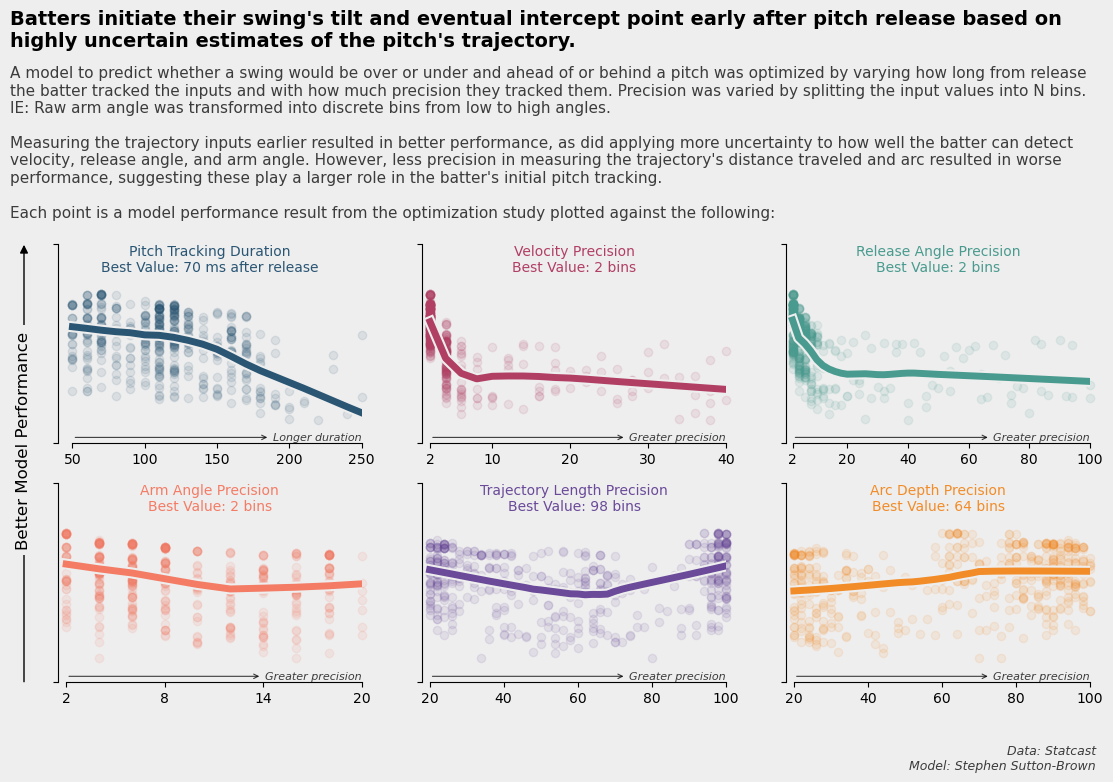

In [13]:
y_column="total_brier"

params_dict = {
    "decision_point_location":{
        "title":"Pitch Tracking Duration",
        "xlimits":[40,250],
        "xbounds":[50,250],
        "xticks":np.arange(50,300,50),
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "visual_angle_change_cuts":{
        "title":"Velocity Precision",
        "xlimits":[1,40],
        "xbounds":[2,40],
        # "xticks":np.arange(2,26,6),
        "xticks":[2,10,20,30,40],
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "release_angle_visual_cuts":{
        "title":"Release Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.22,
        "rank":3,
    },
    "arm_angle_cuts":{
        "title":"Arm Angle Precision",
        "xlimits":[1.5,20],
        "xbounds":[2,20],
        "xticks":np.arange(2,26,6),
        "importance":0.06,
        "rank":4,
    },
    "tot_distance_cuts":{
        "title":"Trajectory Length Precision",
        "xlimits":[18,100],
        "xbounds":[20,100],
        "xticks":np.arange(20,120,20),
        "importance":0.02,
        "rank":5,
    },
    "arc_depth_cuts":{
        "title":"Arc Depth Precision",
        "xlimits":[18,100],
        "xbounds":[20,100],
        "xticks":np.arange(20,120,20),
        "importance":0.01,
        "rank":6,
    },
}
    
fig,axs=plt.subplots(
    2,
    3,
    facecolor="#eeeeee",
    figsize=(12, 6),
)

flat_ax=axs.flatten()

_plot_data=(
    results_df
    .assign(total_brier=lambda df:1-df["total_brier"])
)

for i, param in enumerate(params_dict.keys()):

    ax=flat_ax[i]
    
    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color="#eeeeee",
        ax=ax,
        lowess=True,
        scatter=False,
        line_kws=dict(lw=8),
    )

    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color=colors[i],
        ax=ax,
        lowess=True,
        scatter=False,
        # line_kws=dict(lw=5,alpha=np.min([1,np.max([0.5,3*params_dict[param]["importance"]])])),
        line_kws=dict(lw=5,alpha=1),
    )

    ax.scatter(
        x=_plot_data[f"params_{param}"],
        y=_plot_data[y_column],
        color=colors[i],
        label=None,
        clip_on=False,
        alpha=0.1,
        # alpha=np.min([0.2,np.max([0.05,.3*params_dict[param]["importance"]])]),
    )

    ax.set(
        ylabel="",
        xlabel="",
        facecolor="#eeeeee",
        yticks=[0.67,0.705],
        # yticklabels=["Worse","Better"],
        xlim=params_dict[param]["xlimits"],
        xticks=params_dict[param]["xticks"],
        yticklabels=[],
    )

    optimal_value=str(results_df.sort_values(by="value").iloc[0][f"params_{param}"])
    suffix=" ms after release" if "deci" in param else " bins"
    optimal_value+=suffix
    importance_value=params_dict[param]["rank"]

    ax.text(
        x=0.5,ha="center",
        y=1.0,va="top",
        transform=ax.transAxes,
        s=f"""{params_dict[param]["title"]}
Best Value: {optimal_value}""",
        color=colors[i],
        fontsize=10,
    )
    
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines["bottom"].set_bounds(params_dict[param]["xbounds"])

    if "deci" not in param.lower():
        ax.annotate(
            "Greater precision",
            xy=(params_dict[param]["xticks"][0], 0.671),
            xytext=(params_dict[param]["xticks"][-1], 0.671),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=8,
            fontstyle="italic",
            arrowprops=dict(arrowstyle="<-", color="black", lw=0.8,alpha=0.75),
            alpha=0.75,
        )
    else:
        ax.annotate(
            "Longer duration",
            xy=(params_dict[param]["xticks"][0], 0.671),
            xytext=(params_dict[param]["xticks"][-1], 0.671),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=8,
            fontstyle="italic",
            arrowprops=dict(arrowstyle="<-", color="black", lw=0.8,alpha=0.75),
            alpha=0.75,
        )

secondary_title=fig.text(
    x=0.0,ha="left",
    y=0.92,va="bottom",
    transform=fig.transFigure,
    s="""A model to predict whether a swing would be over or under and ahead of or behind a pitch was optimized by varying how long from release
the batter tracked the inputs and with how much precision they tracked them. Precision was varied by splitting the input values into N bins. 
IE: Raw arm angle was transformed into discrete bins from low to high angles.

Measuring the trajectory inputs earlier resulted in better performance, as did applying more uncertainty to how well the batter can detect
velocity, release angle, and arm angle. However, less precision in measuring the trajectory's distance traveled and arc resulted in worse 
performance, suggesting these play a larger role in the batter's initial pitch tracking.

Each point is a model performance result from the optimization study plotted against the following:""",
    fontsize=11,
    # weight="bold",
    alpha=0.75,
)

main_title=ax.annotate(
    xy=(0,1.1),ha="left",va="bottom",
    xycoords=secondary_title,
    text="""Batters initiate their swing's tilt and eventual intercept point early after pitch release based on 
highly uncertain estimates of the pitch's trajectory.""",
    fontsize=14,
    weight="bold",
)

ax.annotate(
    "",
    xy=(0.02, 0.9),
    xytext=(0.02, 0.1625),
    xycoords="figure fraction",
    textcoords="figure fraction",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    arrowprops=dict(
        arrowstyle="-|>",
        color="black",
        lw=1,
    ),
)

ax.annotate(
    "Better Model Performance",
    xy=(0.02, 0.825),
    xytext=(0.02, .57),
    xycoords="figure fraction",
    textcoords="figure fraction",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    bbox=dict(
        facecolor="#eeeeee",
        edgecolor="none",
    ),
)

fig.text(
    x=0.905,ha="right",
    y=0.0,va="bottom",
    s="""Data: Statcast
Model: Stephen Sutton-Brown""",
    fontstyle="italic",
    alpha=0.75,
    fontsize=9,
)

fig.subplots_adjust(left=0.04,bottom=0.15)
plt.show()

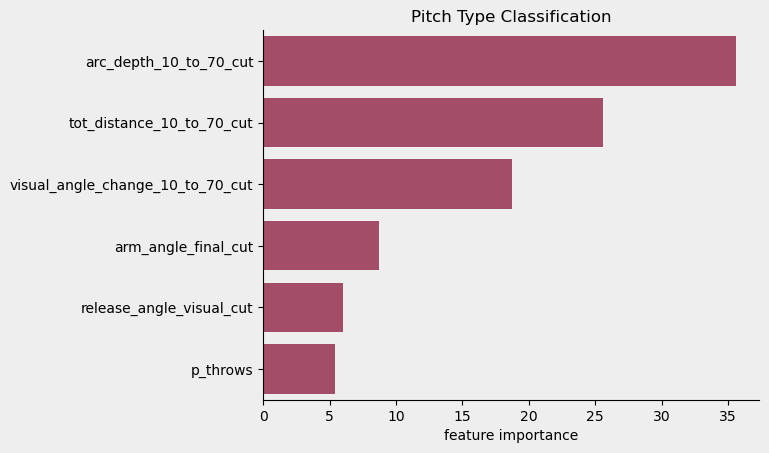

In [14]:
arm_angle_cuts=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_arm_angle_cuts)
tot_distance_cuts=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_tot_distance_cuts)
arc_depth_cuts=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_arc_depth_cuts)
visual_angle_change_cuts=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_visual_angle_change_cuts)
decision_point_location=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_decision_point_location)
release_angle_visual_cuts=int(results_df.sort_values(by="value",ascending=True).iloc[0].params_release_angle_visual_cuts)
dec_pt_loc=1*decision_point_location

swing_df = pl.from_pandas(add_arc_meas(swing_df.to_pandas(),dec_pt_loc))

swing_df = swing_df.with_columns(
    pl.col("arm_angle_final")
    .qcut(arm_angle_cuts, labels=[str(_) for _ in np.arange(arm_angle_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias("arm_angle_final_cut"),
    pl.col("release_angle_visual")
    .qcut(release_angle_visual_cuts, labels=[str(_) for _ in np.arange(release_angle_visual_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias("release_angle_visual_cut"),
    pl.col(f"tot_distance_10_to_{dec_pt_loc}")
    .qcut(tot_distance_cuts, labels=[str(_) for _ in np.arange(tot_distance_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"tot_distance_10_to_{dec_pt_loc}_cut"),
    pl.col(f"arc_depth_10_to_{dec_pt_loc}")
    .qcut(arc_depth_cuts, labels=[str(_) for _ in np.arange(arc_depth_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"arc_depth_10_to_{dec_pt_loc}_cut"),
    pl.col(f"visual_angle_change_10_to_{dec_pt_loc}")
    .qcut(visual_angle_change_cuts, labels=[str(_) for _ in np.arange(visual_angle_change_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"visual_angle_change_10_to_{dec_pt_loc}_cut"),
)

swing_df, under_auc, ahead_auc, total_auc, under_brier, ahead_brier, total_brier = update_predicted_pitch_types(
    swing_df,
    pred_pitch_type_x_vars=[
        "arm_angle_final_cut",
        f"tot_distance_10_to_{dec_pt_loc}_cut",
        f"arc_depth_10_to_{dec_pt_loc}_cut",
        f"visual_angle_change_10_to_{dec_pt_loc}_cut",  
        "release_angle_visual_cut",
        "p_throws",
    ],
    refit=False,
    catboost_verbose=False,
    pitch_type_column=pitch_type_column,
    predicted_pitch_types_model_name="optimized_pitch_cluster_catboost",
)

plot_feature_importances(
    predicted_pitch_types_model_name="optimized_pitch_cluster_catboost",
    title="Pitch Type Classification",
)

In [16]:
statcast_feather_name=".\statcast_pickles\\statcast_2024_raw.feather"

df = full_df_modifications(
    pl.read_ipc(statcast_feather_name)
    .filter(~(pl.col("pitch_type").is_null()|pl.col("pitch_type").is_in(["EP","PO","SC"])))
)

In [17]:
df=df.with_columns(
    pl.col("pfx_x").alias("api_break_x"),
    pl.when(pl.col("p_throws")=="R").then(pl.col("plate_x").mul(-1)).otherwise(pl.col("plate_x")).alias("plate_x_pit_flip"),
)

df = pl.from_pandas(add_movement_vs_expected(
    df.to_pandas(),
    [
        "arm_angle_final",
        "release_angle_visual",        
    ],
    ["api_break_z_with_gravity","api_break_x_arm"],
    pitch_type_column=pitch_type_column,
))

for cluster in df["pitch_cluster"].unique():
    df = df.with_columns(
        pl.when(pl.col("p_throws")=="R")
        .then(pl.col(f"cluster_{cluster}_pred_mu_api_break_x_arm").mul(-1))
        .otherwise(pl.col(f"cluster_{cluster}_pred_mu_api_break_x_arm"))
    .alias(f"cluster_{cluster}_pred_mu_api_break_x"),
    )

In [18]:
df = (
    df
    .drop_nulls(
        subset=[col for col in 
                [
                    "arm_angle_final",
                    "release_angle_visual",
                    "api_break_z_with_gravity",
                    "api_break_x_arm",
                    "tot_distance_10_to_250",
                    "arc_depth_10_to_250",
                    "visual_angle_change_10_to_250",
                    "p_throws",
                    "plate_x",
                    "plate_z",
                    "is_swing",
                    "is_called_strike",
                ] if col in df.columns]
    )
)

In [19]:
from pygam import LinearGAM, s, te, LogisticGAM, GAM

cs_gam=GAM(
    terms=s(0)+s(1),
    distribution="binomial",
    link="logit",
)

fit_data = df.filter(pl.col("is_take")==1).select(["plate_x","plate_z","is_called_strike"]).to_pandas().dropna()

cs_gam.fit(
    X=fit_data[["plate_x","plate_z"]],
    y=fit_data["is_called_strike"],
)

df=df.drop([col for col in ["cs_prob_raw"] if col in df.columns]).with_columns(
    cs_prob_raw=cs_gam.predict(df[["plate_x","plate_z"]])
)

In [20]:
if rerun_optuna:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    
    def print_callback(study_three, trial):
        print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")
        
        if trial.number % 5 == 0:
            print(f"Current best value: {study_three.best_value} with params: {study_three.best_params}")
            print("-" * 50)
    
    trial_log = []
    
    def objective(trial):
    
        global df
        global pitch_type_column
        global cs_gam
    
        arm_angle_cuts=trial.suggest_int("arm_angle_cuts",1,50)*2
        tot_distance_cuts=trial.suggest_int("tot_distance_cuts",1,50)*2
        arc_depth_cuts=trial.suggest_int("arc_depth_cuts",1,50)*2
        visual_angle_change_cuts=trial.suggest_int("visual_angle_change_cuts",1,50)*2
        decision_point_location=trial.suggest_int("decision_point_location",5,35)
        release_angle_visual_cuts=trial.suggest_int("release_angle_visual_cuts",1,50)*2
        dec_pt_loc=10*decision_point_location
    
        df = pl.from_pandas(add_arc_meas(df.to_pandas(),dec_pt_loc))
        
        df = df.with_columns(
            pl.col("arm_angle_final")
            .qcut(arm_angle_cuts, labels=[str(_) for _ in np.arange(arm_angle_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias("arm_angle_final_cut"),
            pl.col("release_angle_visual")
            .qcut(release_angle_visual_cuts, labels=[str(_) for _ in np.arange(release_angle_visual_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias("release_angle_visual_cut"),
            pl.col(f"tot_distance_10_to_{dec_pt_loc}")
            .qcut(tot_distance_cuts, labels=[str(_) for _ in np.arange(tot_distance_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"tot_distance_10_to_{dec_pt_loc}_cut"),
            pl.col(f"arc_depth_10_to_{dec_pt_loc}")
            .qcut(arc_depth_cuts, labels=[str(_) for _ in np.arange(arc_depth_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"arc_depth_10_to_{dec_pt_loc}_cut"),
            pl.col(f"visual_angle_change_10_to_{dec_pt_loc}")
            .qcut(visual_angle_change_cuts, labels=[str(_) for _ in np.arange(visual_angle_change_cuts)], allow_duplicates=True)
            .cast(pl.Int32)
            .alias(f"visual_angle_change_10_to_{dec_pt_loc}_cut"),
        )
        
        df=pl.from_pandas(add_predicted_pitch_types_catboost_v2(
            df.to_pandas(),
            x_vars=[
                "arm_angle_final_cut",
                f"tot_distance_10_to_{dec_pt_loc}_cut",
                f"arc_depth_10_to_{dec_pt_loc}_cut",
                f"visual_angle_change_10_to_{dec_pt_loc}_cut",  
                "release_angle_visual_cut",
                "p_throws",
            ],
            refit=True,
            catboost_verbose=False,
            pitch_type_column=pitch_type_column,
            predicted_pitch_types_model_name="optuna_pitch_cluster_catboost",
            prediction_suffix="_init_traj_w_uncertainty",
        ))
        
        df=add_pred_movement_total(df,"_init_traj_w_uncertainty")
        df=calculate_cs_prob_pred(df,cs_gam)
        
        corr=float(
            df
            .filter(pl.col("strikes")==2)
            .filter(pl.col("balls")<3)
            [["is_swing","cs_prob_wtd_init_traj_w_uncertainty"]]
            .to_pandas().corr()
            .loc["is_swing","cs_prob_wtd_init_traj_w_uncertainty"]
        )
    
        return corr
    
    sampler = TPESampler(seed=3024)
    
    swing_gam_model_opt = optuna.create_study(
        study_name="swing_gam_model_opt", 
        direction="maximize", 
        sampler=sampler,
    )
    
    swing_gam_model_opt.optimize(
        objective, 
        n_trials=500, 
        callbacks=[print_callback],
    )
    
    best_trial = swing_gam_model_opt.best_trial
    
    swing_gam_model_opt.trials_dataframe().copy().to_csv(f"swing_gam_model_opt_results_{today_string}_{pitch_type_column}.csv")
    
    provide_optuna_results(swing_gam_model_opt)
    plot_study_results_gam(swing_gam_model_opt.trials_dataframe().copy())

In [21]:
results_df=pd.read_csv(f"swing_gam_model_opt_results_{load_string}_{pitch_type_column}.csv").dropna(subset=["value"])

for cut_col in [col for col in results_df.columns if "cut" in col]:
    results_df[cut_col] = pd.read_csv(f"swing_gam_model_opt_results_{load_string}_{pitch_type_column}.csv").dropna(subset=["value"])[cut_col].mul(2).values

results_df = results_df.assign(params_decision_point_location=lambda df:df["params_decision_point_location"].mul(10))

In [22]:
params_dict = {
    "decision_point_location":{
        "title":"Pitch Tracking Duration",
        "xlimits":[40,350],
        "xbounds":[50,350],
        "xticks":np.arange(50,400,50),
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "visual_angle_change_cuts":{
        "title":"Velocity Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "release_angle_visual_cuts":{
        "title":"Release Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.22,
        "rank":3,
    },
    "arm_angle_cuts":{
        "title":"Arm Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.06,
        "rank":4,
    },
    "tot_distance_cuts":{
        "title":"Trajectory Length Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.02,
        "rank":5,
    },
    "arc_depth_cuts":{
        "title":"Arc Depth Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.01,
        "rank":6,
    },
}
    

value


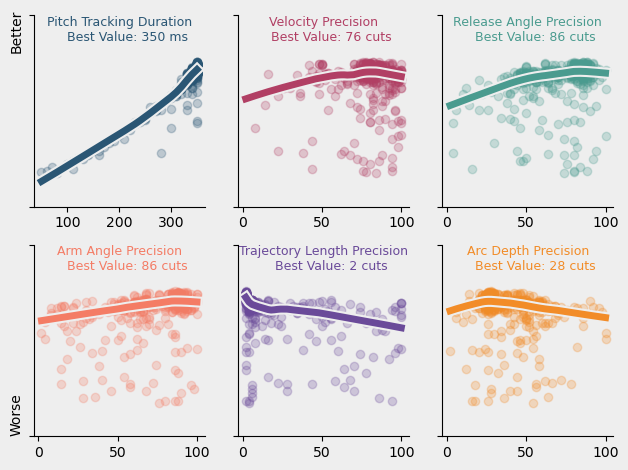

In [23]:
params = [col.split("params_")[1] for col in [_ for _ in results_df.columns if _.startswith("params_") and "extens" not in _]]
param_cols = 3
y_column="value"
for y_column in ["value"]:
    print(y_column)
    
    fig,axs=plt.subplots(math.ceil(len(params)/3),param_cols,facecolor="#eeeeee")
    flat_ax=axs.flatten()
    
    for i, param in enumerate(params_dict.keys()):
        ax=flat_ax[i]
        
        sns.regplot(
            data=results_df,
            x=f"params_{param}",
            y=y_column,
            color="#eeeeee",
            ax=ax,
            lowess=True,
            scatter=False,
            line_kws=dict(lw=8),
        )
    
        sns.regplot(
            data=results_df,
            x=f"params_{param}",
            y=y_column,
            color=colors[i],
            ax=ax,
            lowess=True,
            scatter=False,
            line_kws=dict(lw=5),
        )
    
        ax.scatter(
            x=results_df[f"params_{param}"],
            y=results_df[y_column],
            color=colors[i],
            label=None,
            # clip_on=False,
            alpha=0.25,
        )
    
        ax.set(
            ylabel="",
            xlabel="",
            facecolor="#eeeeee",
            # xlim=params_dict[param]["xlimits"],
            # xticks=params_dict[param]["xticks"],
            ylim=(0.51,0.535),
            yticks=[0.51,0.535],
            # yticklabels=["Worse","Better"],
        )
        
        if i==0:
            ax.set_yticklabels(["","Better"],rotation=90)
        elif i==3:
            ax.set_yticklabels(["Worse",""],rotation=90,va="bottom")
        else:
            ax.set_yticklabels([])
    
        optimal_value=str(results_df.sort_values(by="value",ascending=False).iloc[0][f"params_{param}"])
        suffix=" ms" if "deci" in param else " cuts"
        optimal_value+=suffix
        importance_value=params_dict[param]["rank"]

        ax.text(
            x=0.5,ha="center",
            y=1.0,va="top",
            transform=ax.transAxes,
            s=f"""{params_dict[param]["title"]}
    Best Value: {optimal_value}""",
            color=colors[i],
            fontsize=9,
        )
        ax.spines[["top", "right"]].set_visible(False)
        # ax.spines["bottom"].set_bounds(params_dict[param]["xbounds"])

    plt.tight_layout()
    plt.show()

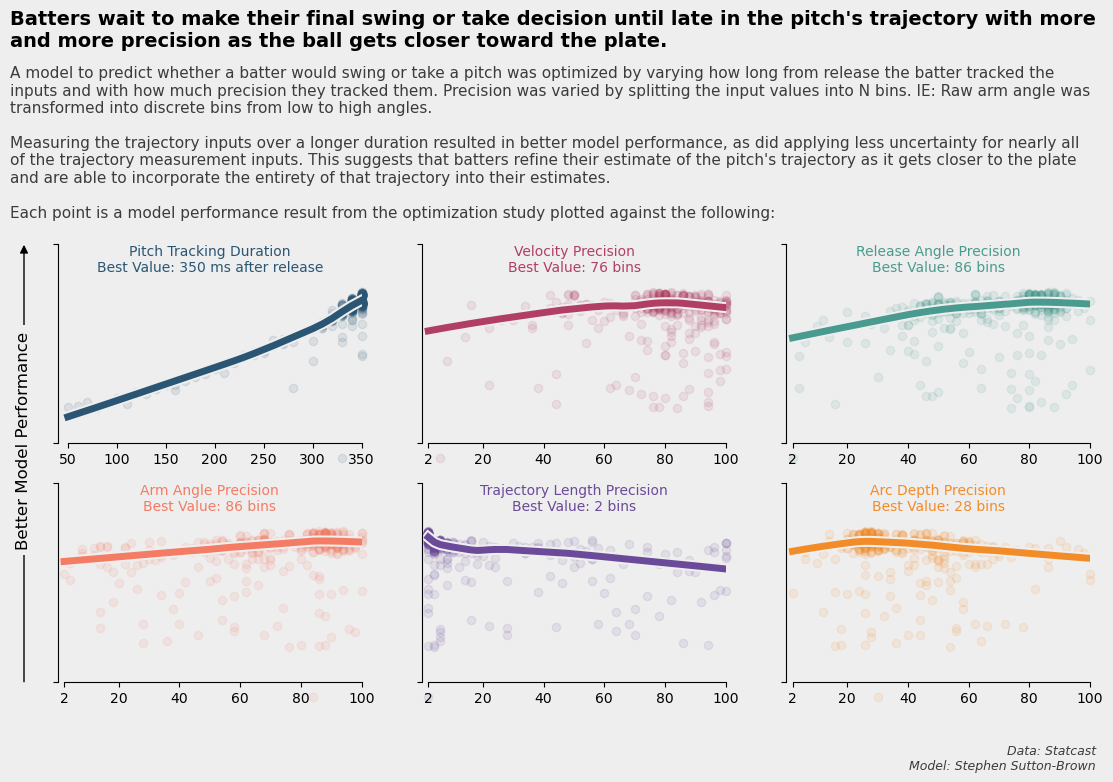

In [24]:
y_column="value"

params_dict = {
    "decision_point_location":{
        "title":"Pitch Tracking Duration",
        "xlimits":[40,350],
        "xbounds":[50,350],
        "xticks":np.arange(50,400,50),
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "visual_angle_change_cuts":{
        "title":"Velocity Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.35,
        "rank":"1 (tie)",
    },
    "release_angle_visual_cuts":{
        "title":"Release Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.22,
        "rank":3,
    },
    "arm_angle_cuts":{
        "title":"Arm Angle Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.06,
        "rank":4,
    },
    "tot_distance_cuts":{
        "title":"Trajectory Length Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.02,
        "rank":5,
    },
    "arc_depth_cuts":{
        "title":"Arc Depth Precision",
        "xlimits":[0,100],
        "xbounds":[2,100],
        "xticks":[2,20,40,60,80,100],
        "importance":0.01,
        "rank":6,
    },
}
    
fig,axs=plt.subplots(
    2,
    3,
    facecolor="#eeeeee",
    figsize=(12, 6),
)

flat_ax=axs.flatten()

_plot_data=(
    results_df
)

for i, param in enumerate(params_dict.keys()):

    ax=flat_ax[i]
    
    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color="#eeeeee",
        ax=ax,
        lowess=True,
        scatter=False,
        line_kws=dict(lw=8),
    )

    sns.regplot(
        data=_plot_data,
        x=f"params_{param}",
        y=y_column,
        color=colors[i],
        ax=ax,
        lowess=True,
        scatter=False,
        line_kws=dict(lw=5,alpha=1),
    )

    ax.scatter(
        x=_plot_data[f"params_{param}"],
        y=_plot_data[y_column],
        color=colors[i],
        label=None,
        clip_on=False,
        alpha=0.1,
    )

    ax.set(
        ylabel="",
        xlabel="",
        facecolor="#eeeeee",
        yticks=[0.51,0.535],
        ylim=(0.51,0.535),
        xlim=params_dict[param]["xlimits"],
        xticks=params_dict[param]["xticks"],
        yticklabels=[],
    )

    optimal_value=str(results_df.sort_values(by="value",ascending=False).iloc[0][f"params_{param}"])
    suffix=" ms after release" if "deci" in param else " bins"
    optimal_value+=suffix
    importance_value=params_dict[param]["rank"]

    ax.text(
        x=0.5,ha="center",
        y=1.0,va="top",
        transform=ax.transAxes,
        s=f"""{params_dict[param]["title"]}
Best Value: {optimal_value}""",
        color=colors[i],
        fontsize=10,
    )
    
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines["bottom"].set_bounds(params_dict[param]["xbounds"])

    if "deci" not in param.lower():
        ax.annotate(
            "Greater precision",
            xy=(params_dict[param]["xticks"][0], 0.6557),
            xytext=(params_dict[param]["xticks"][-1], 0.6557),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=8,
            fontstyle="italic",
            arrowprops=dict(arrowstyle="<-", color="black", lw=0.8,alpha=0.75),
            alpha=0.75,
        )
    else:
        ax.annotate(
            "Longer duration",
            xy=(params_dict[param]["xticks"][0], 0.6557),
            xytext=(params_dict[param]["xticks"][-1], 0.6557),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=8,
            fontstyle="italic",
            arrowprops=dict(arrowstyle="<-", color="black", lw=0.8,alpha=0.75),
            alpha=0.75,
        )

secondary_title=fig.text(
    x=0.0,ha="left",
    y=0.92,va="bottom",
    transform=fig.transFigure,
    s="""A model to predict whether a batter would swing or take a pitch was optimized by varying how long from release the batter tracked the
inputs and with how much precision they tracked them. Precision was varied by splitting the input values into N bins. IE: Raw arm angle was
transformed into discrete bins from low to high angles.

Measuring the trajectory inputs over a longer duration resulted in better model performance, as did applying less uncertainty for nearly all
of the trajectory measurement inputs. This suggests that batters refine their estimate of the pitch's trajectory as it gets closer to the plate
and are able to incorporate the entirety of that trajectory into their estimates.

Each point is a model performance result from the optimization study plotted against the following:""",
    fontsize=11,
    alpha=0.75,
)

main_title=ax.annotate(
    xy=(0,1.1),ha="left",va="bottom",
    xycoords=secondary_title,
    text="""Batters wait to make their final swing or take decision until late in the pitch's trajectory with more
and more precision as the ball gets closer toward the plate.""",
    fontsize=14,
    weight="bold",
)

ax.annotate(
    "",
    xy=(0.02, 0.9),
    xytext=(0.02, 0.1625),
    xycoords="figure fraction",
    textcoords="figure fraction",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    arrowprops=dict(
        arrowstyle="-|>",
        color="black",
        lw=1,
    ),
)

ax.annotate(
    "Better Model Performance",
    xy=(0.02, 0.825),
    xytext=(0.02, .57),
    xycoords="figure fraction",
    textcoords="figure fraction",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    bbox=dict(
        facecolor="#eeeeee",
        edgecolor="none",
    ),
)

fig.text(
    x=0.905,ha="right",
    y=0.0,va="bottom",
    s="""Data: Statcast
Model: Stephen Sutton-Brown""",
    fontstyle="italic",
    alpha=0.75,
    fontsize=9,
)

fig.subplots_adjust(left=0.04,bottom=0.15)
plt.show()

In [26]:
arm_angle_cuts=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_arm_angle_cuts)
tot_distance_cuts=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_tot_distance_cuts)
arc_depth_cuts=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_arc_depth_cuts)
visual_angle_change_cuts=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_visual_angle_change_cuts)
decision_point_location=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_decision_point_location)
release_angle_visual_cuts=int(results_df.sort_values(by="value",ascending=False).iloc[0].params_release_angle_visual_cuts)
dec_pt_loc=1*decision_point_location

df = pl.from_pandas(add_arc_meas(df.to_pandas(),dec_pt_loc))

df = df.with_columns(
    pl.col("arm_angle_final")
    .qcut(arm_angle_cuts, labels=[str(_) for _ in np.arange(arm_angle_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias("arm_angle_final_cut"),
    pl.col("release_angle_visual")
    .qcut(release_angle_visual_cuts, labels=[str(_) for _ in np.arange(release_angle_visual_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias("release_angle_visual_cut"),
    pl.col(f"tot_distance_10_to_{dec_pt_loc}")
    .qcut(tot_distance_cuts, labels=[str(_) for _ in np.arange(tot_distance_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"tot_distance_10_to_{dec_pt_loc}_cut"),
    pl.col(f"arc_depth_10_to_{dec_pt_loc}")
    .qcut(arc_depth_cuts, labels=[str(_) for _ in np.arange(arc_depth_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"arc_depth_10_to_{dec_pt_loc}_cut"),
    pl.col(f"visual_angle_change_10_to_{dec_pt_loc}")
    .qcut(visual_angle_change_cuts, labels=[str(_) for _ in np.arange(visual_angle_change_cuts)], allow_duplicates=True)
    .cast(pl.Int32)
    .alias(f"visual_angle_change_10_to_{dec_pt_loc}_cut"),
)

df=pl.from_pandas(add_predicted_pitch_types_catboost_v2(
    df.to_pandas(),
    x_vars=[
        "arm_angle_final_cut",
        f"tot_distance_10_to_{dec_pt_loc}_cut",
        f"arc_depth_10_to_{dec_pt_loc}_cut",
        f"visual_angle_change_10_to_{dec_pt_loc}_cut",  
        "release_angle_visual_cut",
        "p_throws",
    ],
    refit=False,
    catboost_verbose=False,
    pitch_type_column=pitch_type_column,
    predicted_pitch_types_model_name="optuna_pitch_cluster_catboost",
    prediction_suffix="_init_traj_w_uncertainty",
))

df=add_pred_movement_total(df,"_init_traj_w_uncertainty")
df=calculate_cs_prob_pred(df,cs_gam)

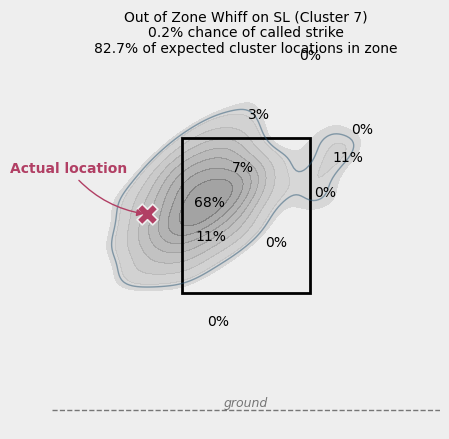

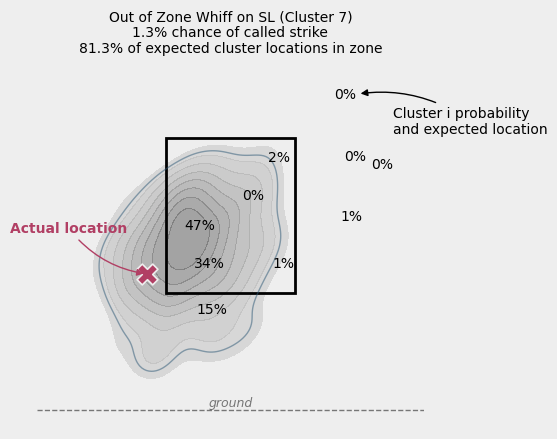

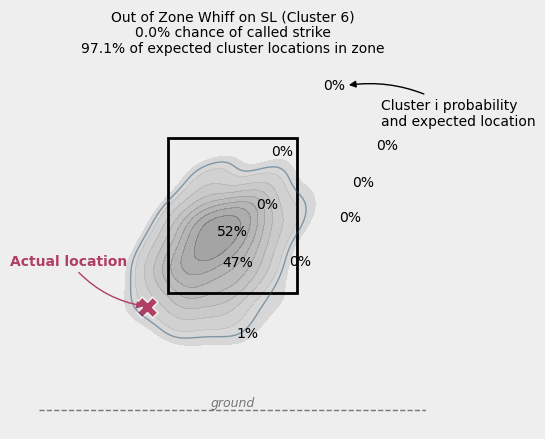

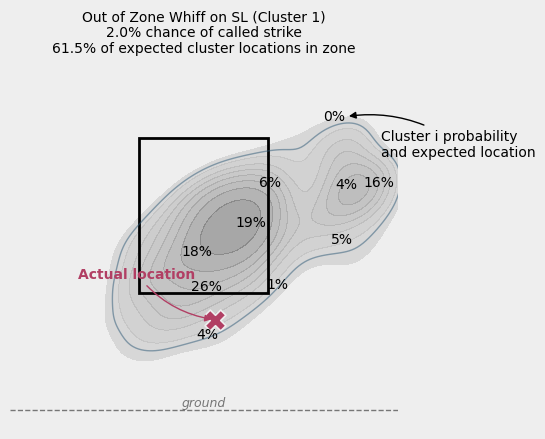

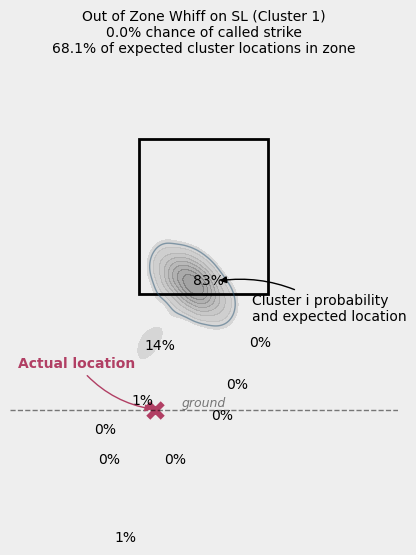

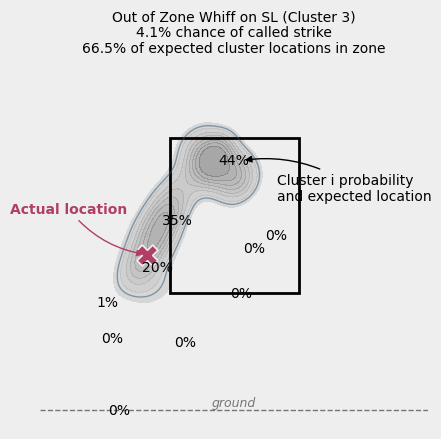

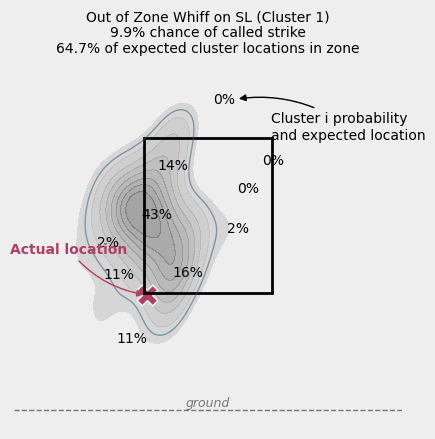

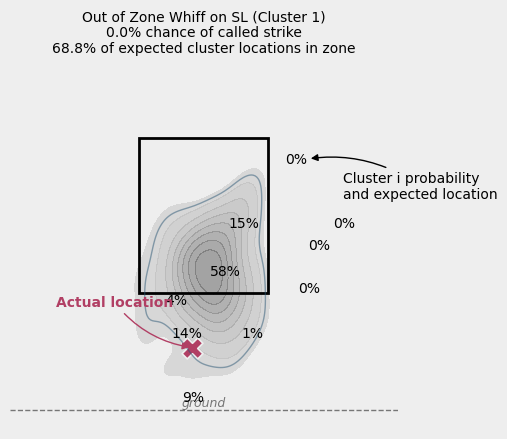

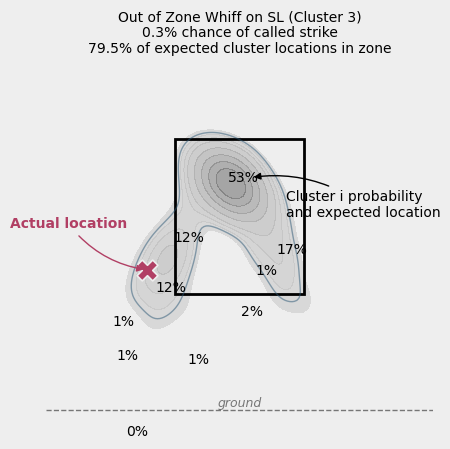

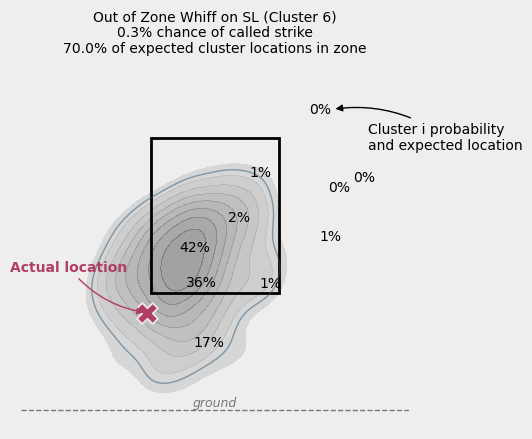

In [28]:
loop_num=0
while loop_num<10:
    loop_num+=1

    plot_data=(
        df
        .filter(pl.col("is_swing")==1)
        .filter(pl.col("cs_prob_raw")<0.1)
        .filter(pl.col("cs_prob_wtd_init_traj_w_uncertainty")>0.6)
        .filter(pl.col("pitch_type")=="SL")
        .filter(pl.col("description")=="swinging_strike")
        .to_pandas()
        .sample(1)
    )

    for cluster_pred_model in [
        "_init_traj_w_uncertainty",
    ]:

        
        fig,ax=plt.subplots(
            facecolor="#eeeeee",
            figsize=(5,6),
        )
        
        big_x = []
        big_y = []
        cluster_analysis=pd.DataFrame(columns=["Cluster","Cluster Probability","Expected x","Expected z"])
        
        for i, cluster in enumerate(df["pitch_cluster"].unique()):
            weight = plot_data[f"cluster_{cluster}_pred{cluster_pred_model}"].values[0]
            random_sample = np.random.multivariate_normal(
                mean=[
                    plot_data[f"cluster_{cluster}_pred_mu_api_break_x_arm"].values[0],
                    plot_data[f"cluster_{cluster}_pred_mu_api_break_z_with_gravity"].values[0]
                ],
                cov=[
                    [plot_data[f"cluster_{cluster}_pred_var_api_break_x_arm"].values[0], 
                     plot_data[f"cluster_{cluster}_pred_corr_api_break_z_with_gravity_api_break_x_arm"].values[0]],
                    [plot_data[f"cluster_{cluster}_pred_corr_api_break_z_with_gravity_api_break_x_arm"].values[0],
                     plot_data[f"cluster_{cluster}_pred_var_api_break_z_with_gravity"].values[0]]
                ],
                size=int(weight*1000)
            )
        
            cluster_analysis.loc[i,"Cluster"]=cluster
            cluster_analysis.loc[i,"Cluster Probability"] = 100*weight
            cluster_analysis.loc[i,"Expected x"]=plot_data[f"cluster_{cluster}_pred_mu_api_break_x_arm"].values[0]-plot_data["api_break_x_arm"].values[0]+plot_data["plate_x_pit_flip"].values[0]
            cluster_analysis.loc[i,"Expected z"]=-plot_data[f"cluster_{cluster}_pred_mu_api_break_z_with_gravity"].values[0]+plot_data["api_break_z_with_gravity"].values[0]+plot_data["plate_z"].values[0]

            if cluster==9:
                ax.annotate(
                    xy=(
                        0.3+plot_data[f"cluster_{cluster}_pred_mu_api_break_x_arm"].values[0]-plot_data["api_break_x_arm"].values[0]+plot_data["plate_x_pit_flip"].values[0],
                        .05-plot_data[f"cluster_{cluster}_pred_mu_api_break_z_with_gravity"].values[0]+plot_data["api_break_z_with_gravity"].values[0]+plot_data["plate_z"].values[0]
                    ),
                    ha="left",
                    va="bottom",
                    xytext=(
                        0.75+plot_data[f"cluster_{cluster}_pred_mu_api_break_x_arm"].values[0]-plot_data["api_break_x_arm"].values[0]+plot_data["plate_x_pit_flip"].values[0],
                        -0.5-plot_data[f"cluster_{cluster}_pred_mu_api_break_z_with_gravity"].values[0]+plot_data["api_break_z_with_gravity"].values[0]+plot_data["plate_z"].values[0]
                    ),
                    text="Cluster i probability\nand expected location",
                    color="black",
                    fontsize=10,
                    arrowprops=dict(
                        color="black",
                        connectionstyle="arc3,rad=0.2",
                        arrowstyle="-|>",
                    ),
                )   
            
            ax.text(
                x=plot_data[f"cluster_{cluster}_pred_mu_api_break_x_arm"].values[0]-plot_data["api_break_x_arm"].values[0]+plot_data["plate_x_pit_flip"].values[0],
                y=-plot_data[f"cluster_{cluster}_pred_mu_api_break_z_with_gravity"].values[0]+plot_data["api_break_z_with_gravity"].values[0]+plot_data["plate_z"].values[0],
                s=f"""{100*weight:.0f}%""",
            )
            
            big_x.append(pd.Series(random_sample[:,0]-plot_data["api_break_x_arm"].values[0]+plot_data["plate_x_pit_flip"].values[0]))
            big_y.append(pd.Series(-random_sample[:,1]+plot_data["api_break_z_with_gravity"].values[0]+plot_data["plate_z"].values[0]))
        
        for col in cluster_analysis.columns:
            if col=="Cluster":
                continue
            else:
                cluster_analysis[col]=cluster_analysis[col].astype(float)
        
        big_x = pd.concat(big_x).values
        big_y = pd.concat(big_y).values
        
        sns.kdeplot(
            x=big_x,
            y=big_y,
            fill=True,
            ax=ax,
            levels=np.minimum(1,np.arange(0.2,1.1,0.1)),
            linewidths=0,
            color="gray",
            alpha=0.5,
        )
        
        sns.kdeplot(
            x=big_x,
            y=big_y,
            fill=False,
            ax=ax,
            levels=[0.25],
            linewidths=1,
            color=COLOR_DICT["BLUE"],
            alpha=0.5,
        )

        ax.annotate(
            xy=(plot_data["plate_x_pit_flip"].mean(),plot_data["plate_z"].mean()),
            ha="right",
            va="bottom",
            xytext=(plot_data["plate_x_pit_flip"].mean()-0.25,plot_data["plate_z"].mean()+0.5),
            text="Actual location",
            color=COLOR_DICT["RED"],
            fontsize=10,
            fontweight="bold",
            arrowprops=dict(
                color=COLOR_DICT["RED"],
                connectionstyle="arc3,rad=0.2",
                arrowstyle="-|>",
            ),
        )      
        
        sns.scatterplot(
            ax=ax,
            data=plot_data,
            x="plate_x_pit_flip",
            y="plate_z",
            marker="X",
            s=225,
            color=COLOR_DICT["RED"],
            alpha=1,
            edgecolor="#eeeeee",
        )
        
        strikezone = patches.Rectangle(
            (-0.83, 1.5),
            1.66,
            2.0,
            linewidth=2,
            edgecolor="black",
            facecolor="none",
        )
        ax.add_patch(strikezone)
        
        ax.spines[["top","right","bottom","left"]].set_visible(False)
        
        ax.set(
            facecolor="#eeeeee",
            xlabel="",
            ylabel="",
            xticks=[],
            yticks=[],
            xlim=(-2.5,2.5),
            ylim=(-0.25,4.5),
        )
        
        ax.axhline(0,color="black",lw=1.0,linestyle="--",alpha=0.5)
        ax.text(
            x=0,
            ha="center",
            y=0,
            va="bottom",
            s="ground",
            fontstyle="italic",
            color="black",
            alpha=0.5,
            fontsize=9,
        )
        
        ax.set_aspect("equal", adjustable="box")

        ax.set_title(
            f"""Out of Zone Whiff on {plot_data["pitch_type"].values[0]} (Cluster {plot_data["pitch_cluster"].values[0]})
{plot_data["cs_prob_raw"].mean()*100:.1f}% chance of called strike
{plot_data[f"cs_prob_wtd{cluster_pred_model}"].mean()*100:.1f}% of expected cluster locations in zone""",
            fontsize=10,
        )

        
        plt.show()